In [1]:
import time
import numpy as np                 # package for numerics
import pandas as pd                # package for data frames  
import matplotlib.pyplot as plt    # package for plotting     



from sklearn.ensemble import RandomForestRegressor    # Random Forest
from sklearn.linear_model import LinearRegression     # Linear Regression 
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,WhiteKernel,
                                              ConstantKernel)


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Cross validations 
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance

# Scores

from sklearn.metrics import mean_absolute_error as mae # Metric 
from sklearn.metrics import r2_score  as r2                 # Metric
from sklearn.metrics import mean_squared_error as mse  

# Optimisation 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Keras Model 
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor


# Other Visual etc 
import seaborn as sns
from matplotlib.patches import Patch  # Thi is a function to generate plot 
from matplotlib import cm
np.random.seed(1338)

# Optimization

from pyswarm import pso  

Using TensorFlow backend.


# Import Data

In [2]:
df1= pd.read_csv("Data.csv", index_col='Datetime', parse_dates=True) 
df2= pd.read_csv("Data2020.csv", index_col='Datetime', parse_dates=True)
df = pd.concat([df1,df2 ])

In [3]:
# shift inputs if needed here !

In [4]:
features=df
features.insert(1,"SMeanT",df.MeanT-df.SetTemp)  # Insert Output
features.SMeanT=features.SMeanT.shift(-1)       # Shift output by 1 place !

In [5]:
# Put Windows to end
windows=['Win_AFT', 'Win_AFB','Win_ARoof', 'Win_Akip', 'Win_BFT', 'Win_BFB', 'Win_Broof', 'Win_BKip','Vfloor_A','Vfloor_B']
features = features[ [ col for col in features.columns if col not in windows ] + windows ]
Names=list(features.columns)
unwanted = { 'group', 'WindD','SMeanT', 'WindDc','hourC','hourS','Rain','MeanC','SetTemp','Spa','WindDC_nan','WindDs'}
Xnames = [e for e in Names if e not in unwanted]
features['group'] = (features.index -features.index[0]).days

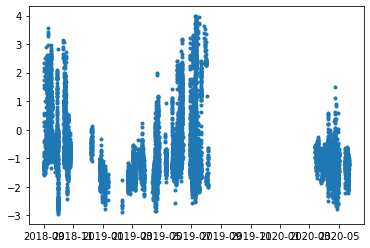

In [6]:
# Filter SMEANT 
features=features.loc[features.SMeanT.between(-3,4),:]
plt.plot(features.SMeanT,'.')

In [7]:
features=features.dropna(axis=0)

# Prapare Data 

In [8]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.30, n_splits=2, random_state = 40).split(features, groups=features['group']))

Train = features.iloc[train_inds]
Test = features.iloc[test_inds]

X = Train[Xnames].values
y = Train["SMeanT"].values  
print("X.shape:  ", X.shape)
print("y.shape:  ", y.shape)

X_test = Test[Xnames].values
y_test = Test["SMeanT"].values  
print("X.shape:  ", X_test.shape)
print("y.shape:  ", y_test.shape)

X.shape:   (9830, 19)
y.shape:   (9830,)
X.shape:   (3987, 19)
y.shape:   (3987,)


In [9]:
group=Train.group
n_splits=5
cv=GroupShuffleSplit(n_splits,random_state=24) 

In [10]:
ng=len(np.unique(features["group"].values))

# Random Fores Hyper Parameter

In [11]:
# Define grid for Optimization 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10,40, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid


RFC = make_pipeline( StandardScaler(), RandomForestRegressor( ) )

random_grid = {'randomforestregressor__n_estimators': n_estimators,
               'randomforestregressor__max_features': max_features,
               'randomforestregressor__max_depth': max_depth,
               'randomforestregressor__min_samples_split': min_samples_split,
               'randomforestregressor__min_samples_leaf': min_samples_leaf,
               'randomforestregressor__bootstrap': bootstrap}

RFC = RandomizedSearchCV(estimator = RFC, param_distributions = random_grid, scoring= 'neg_mean_squared_error',cv = cv, n_iter =30,verbose=10, random_state=42, n_jobs = 2,iid=True)
# Fit the random search model

RFC.fit(X, y,group)
scores = RFC.cv_results_['mean_test_score']
scores_std = RFC.cv_results_['std_test_score']

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  6.4min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 10.3min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 16.1min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 17.4min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 19.5min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 20.8min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 22.0min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 23.7min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 27.9min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 34.5min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed: 43.1min
[Parallel(

Scores for each itteration is:  [-0.19224668 -0.23299881 -0.18304958 -0.19215246 -0.12535879 -0.24234447
 -0.12466706 -0.12500931 -0.19442807 -0.20064964 -0.18422084 -0.19638842
 -0.18354325 -0.12189014 -0.18215133 -0.18681877 -0.18784253 -0.18436391
 -0.18859285 -0.19312893 -0.12112992 -0.23273854 -0.18815961 -0.18169263
 -0.23980623 -0.1838249  -0.12676653 -0.23240095 -0.23279549 -0.19554822]
 
Best parameter found is:  {'randomforestregressor__n_estimators': 325, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 30, 'randomforestregressor__bootstrap': True}
Best score is : -0.12112991692650445


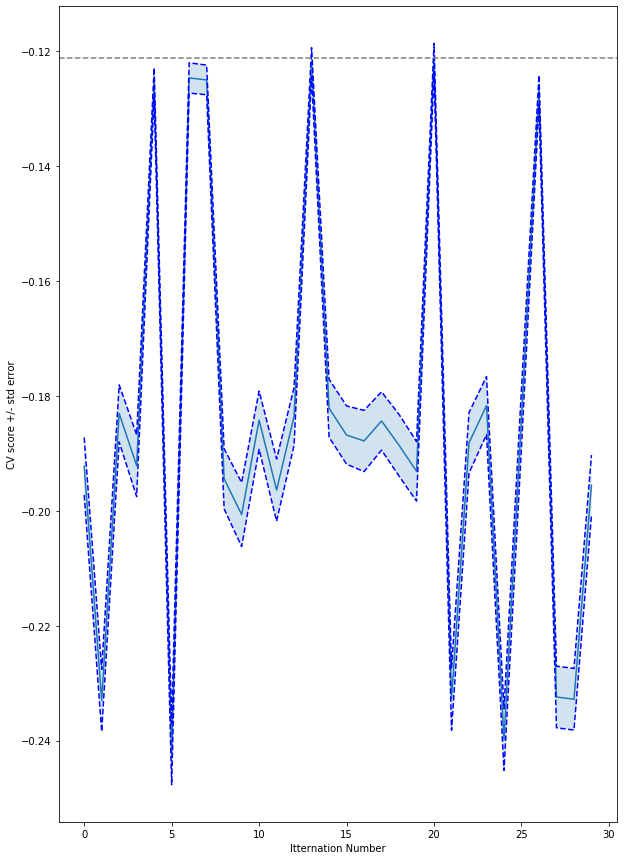

In [12]:
plt.figure().set_size_inches(10,15)
plt.plot(np.arange(len(scores)), scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(ng)

plt.plot(np.arange(len(scores)), scores + std_error, 'b--')
plt.plot(np.arange(len(scores)), scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(np.arange(len(scores)), scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('Itternation Number')
plt.axhline(np.max(scores), linestyle='--', color='.5')
#plt.savefig('RFOP.png')

print("Scores for each itteration is: ", scores)
print(" ")
print("Best parameter found is: ", RFC.best_params_)
print("Best score is :", scores[RFC.best_index_])

In [13]:
 RFC.best_params_

{'randomforestregressor__n_estimators': 325,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__min_samples_leaf': 4,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__max_depth': 30,
 'randomforestregressor__bootstrap': True}

# Random Forest Final 

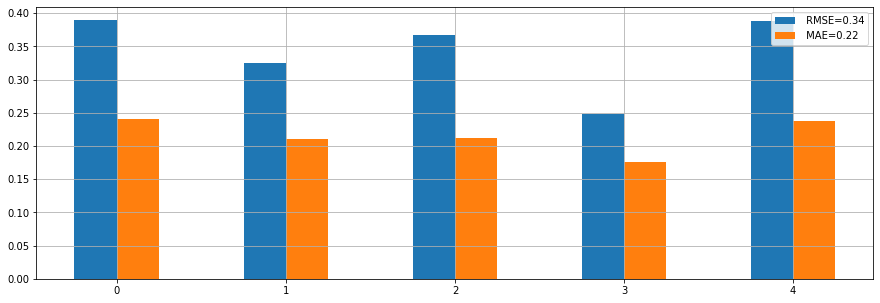

In [14]:
RF=RFC.best_estimator_
scoring = {'mse':"neg_mean_squared_error", 'mae': 'neg_mean_absolute_error',
           'r2': 'r2'}

scor= cross_validate(RF, X, y, group, cv =cv,scoring=scoring)

mse1 = -scor['test_mse']
mae1 = -scor['test_mae']
r21=  -scor['test_r2']

labels = ['0','1', '2', '3', '4']
mse1 = np.sqrt(-scor['test_mse'])
mae1 = -scor['test_mae']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, mse1, width, label=" RMSE=%.2f"%(np.mean(mse1)),)
rects2 = ax.bar(x + width/2, mae1, width, label=" MAE=%.2f"%(np.mean(mae1)),)
plt.legend()
plt.grid()

In [15]:
print(np.mean(scor['test_r2']))

0.8875836463674218


C:\Users\au327049\Conda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\au327049\Conda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


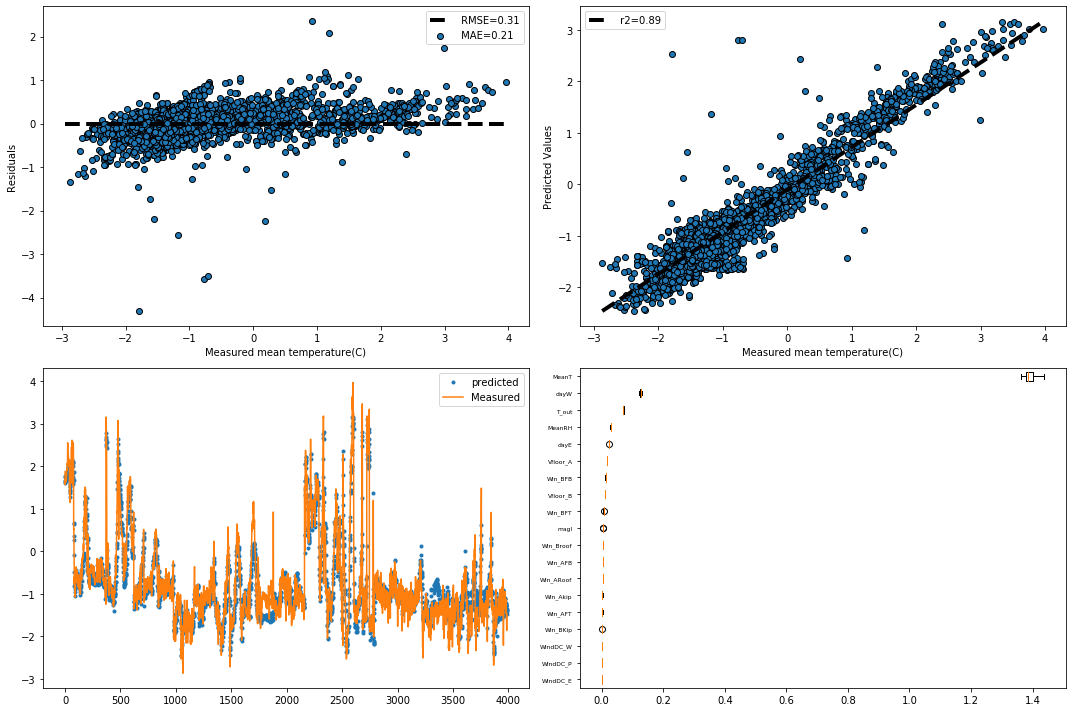

In [16]:
Y_pt=RF.predict(X_test)

mse1 = mse(Y_pt,y_test)
mae1 = mae(Y_pt,y_test)
r21=  r2(Y_pt,y_test)

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.scatter(y_test,y_test-Y_pt, edgecolors=(0, 0, 0), label=" MAE=%.2f"%(mae1),)
plt.plot([y.min(),y.max()], [0,0], 'k--', lw=4, label=" RMSE=%.2f"%(np.sqrt(mse1)),)
plt.xlabel('Measured mean temperature(C)')
plt.ylabel('Residuals')
plt.legend()


plt.subplot(2,2,2)
plt.scatter(y_test,Y_pt, edgecolors=(0, 0, 0))
plt.plot([y_test.min(),y_test.max()], [Y_pt.min(),Y_pt.max()], 'k--', lw=4,label=" r2=%.2f"%(r21),)
plt.xlabel('Measured mean temperature(C)')
plt.ylabel('Predicted Values')
plt.legend()


ax=plt.subplot(2,2,3)
plt.plot(Y_pt,'.',label="predicted",)
plt.plot(y_test,label="Measured")
plt.legend()

import eli5
from eli5.sklearn import PermutationImportance

ax=plt.subplot(2,2,4)
feature_names = np.r_[Xnames]
result = permutation_importance(RF, X, y, n_repeats=20,
                               random_state=42)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(result.importances[sorted_idx].T, vert=False)
ax.set_yticklabels(labels=feature_names[sorted_idx], minor=False,fontsize=6)
plt.tight_layout()
plt.show()  


In [17]:
import pickle
filename = 'RF_Model.sav'
pickle.dump(RF, open(filename, 'wb'))

In [18]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(RF, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = Xnames)

Weight,Feature
1.2288 ± 0.0299,MeanT
0.0886 ± 0.0011,dayW
0.0680 ± 0.0054,T_out
0.0288 ± 0.0025,MeanRH
0.0143 ± 0.0010,dayE
0.0143 ± 0.0014,Vfloor_A
0.0116 ± 0.0020,Win_BFB
0.0079 ± 0.0009,Vfloor_B
0.0047 ± 0.0013,Win_BFT
0.0045 ± 0.0010,Win_Broof
